# Оценка показателя Херста методом Backward Detrended Moving Average (BDMA/DMA)

В этом ноутбуке демонстрируется реализация метода **Backward DMA (BDMA)** для оценки показателя Херста $H$ по временным рядам типа fBm и fGn.

## Теоретическая основа

Метод опирается на следующие шаги для исходного временного ряда $x(t)$, $t = 1, \dots, N$:

### 1. Интегрирование (опционально)
- Если `n_integral = 1`, строится интегрированный ряд
  $$
  y(t) = \sum_{i=1}^{t} x(i),
  $$
  что соответствует модели fractional Brownian motion (fBm), а исходный ряд интерпретируется как fractional Gaussian noise (fGn) — приращения процесса fBm.
- Если `n_integral = 0`, используется исходный ряд $x(t)$ как есть.

Таким образом, один и тот же алгоритм применим и к fBm, и к fGn.

### 2. Построение локального тренда (backward moving average)
Для заданного масштаба окна $n$ (где $10 \le n \le N/4$) вычисляется обратное скользящее среднее:
$$
\tilde y(t) = \frac{1}{n} \sum_{k=0}^{n-1} y(t-k), \quad t = n, n+1, \dots, N.
$$
Этот вариант называется **backward DMA (BDMA)**: он не использует будущие значения ряда, что делает его применимым к потоковым данным.

### 3. Функция флуктуаций
Определяется как среднеквадратичное отклонение от локального тренда:
$$
F(n) = \sqrt{ \frac{1}{M} \sum_{t=n}^{N} \bigl( y(t) - \tilde y(t) \bigr)^2 },
$$
где $M = N - n + 1$ — количество точек для данного масштаба $n$.

### 4. Оценка показателя Херста $H$
При выполнении степенного закона
$$
F(n) \sim n^H,
$$
показатель Херста оценивается как наклон линейной регрессии зависимости $\log F(n)$ от $\log n$ в выбранном диапазоне масштабов.

In [21]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

%matplotlib inline

np.random.seed(42)


In [22]:
from StatTools.generators.kasdin_generator import create_kasdin_generator

In [23]:
def estimate_hurst(F, s):
    return stats.linregress(np.log(s), np.log(F)).slope


def generate_fractional_noise(h: float, length: int):
    """Generate fGn using Kasdin filter method (same as in test_fa)."""
    return create_kasdin_generator(h, length=length).get_full_sequence()


def generate_fbm(h: float, length: int):
    """Integrate fGn to produce fBm."""
    return np.cumsum(generate_fractional_noise(h, length))


## Пример 1. Оценка H для fGn с \\(H = 0.7\\)

Сгенерируем один временной ряд длины \\(N = 2^{14}\\), оценим функцию \\(F(n)\\)
и показатель Херста \\(H\\). Построим:

* временной ряд;
* зависимость \\(\\log F(n)\\) от \\(\\log n\\) с линейной аппроксимацией.

In [24]:
from StatTools.analysis.bma import bma
from StatTools.analysis.dpcca import dpcca

H_true = 0.70, H_est = 0.747


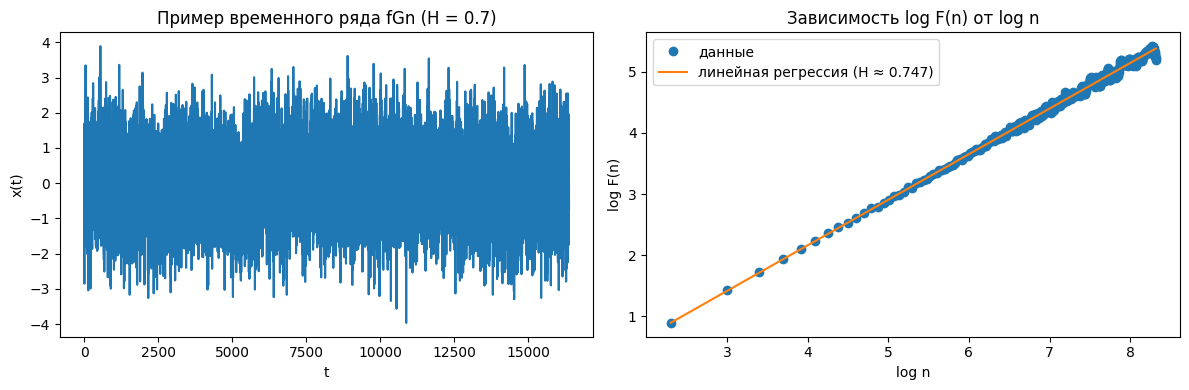

In [27]:
H_true = 0.7
N = 2 ** 14

sig_fgn = generate_fractional_noise(H_true, N)

# Масштабы от 10 до N/4
scales = np.arange(10, N // 4, 10)

F_vals, used_scales = bma(sig_fgn, s=scales, n_integral=1, step=0.5)
H_est = estimate_hurst(F_vals, used_scales)

print(f"H_true = {H_true:.2f}, H_est = {H_est:.3f}")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Временной ряд
axes[0].plot(sig_fgn)
axes[0].set_title("Пример временного ряда fGn (H = 0.7)")
axes[0].set_xlabel("t")
axes[0].set_ylabel("x(t)")

# log-log F(n)
axes[1].plot(np.log(used_scales), np.log(F_vals), marker="o", linestyle="None", label="данные")

# Прямая регрессии
lr = stats.linregress(np.log(used_scales), np.log(F_vals))
fit_line = lr.intercept + lr.slope * np.log(used_scales)
axes[1].plot(np.log(used_scales), fit_line, label=f"линейная регрессия (H ≈ {lr.slope:.3f})")

axes[1].set_xlabel("log n")
axes[1].set_ylabel("log F(n)")
axes[1].set_title("Зависимость log F(n) от log n")
axes[1].legend()

plt.tight_layout()
plt.savefig("fgn_loglog_regression", dpi=300, format="svg")
plt.show()


## Пример 2. Сравнение fBm и fGn при различных H

Для \(H = 0.5\):

* fBm соответствует обычному броуновскому движению,
* fGn — его приращения (белый шум).

Проверим, что:

* при `n_integral = 0` (fBm) и `n_integral = 1` (fGn) оценки Херста близки к 0.5.


In [28]:
H_values = [0.1, 0.2, 0.4, 0.5, 0.6, 0.8, 1, 1.2, 1.4, 1.7, 1.9, 2.0]
N = 2 ** 14

# Store results
H_fbm_estimates = []
H_fgn_estimates = []

for H_true in H_values:
    sig_fgn = generate_fractional_noise(H_true, N)
    sig_fbm = np.cumsum(sig_fgn)

    scales = np.arange(10, N // 4, 10)

    # fBm: n_integral = 0
    F_fbm, s_fbm = bma(sig_fbm, s=scales, n_integral=0, step=0.5)
    H_fbm = estimate_hurst(F_fbm, s_fbm)
    H_fbm_estimates.append(H_fbm)

    # fGn: n_integral = 1
    F_fgn, s_fgn = bma(sig_fgn, s=scales, n_integral=1, step=0.5)
    H_fgn = estimate_hurst(F_fgn, s_fgn)
    H_fgn_estimates.append(H_fgn)

    print(f"H_true = {H_true}")
    print(f"H_est (fBm, n_integral=0) = {H_fbm:.3f}")
    print(f"H_est (fGn, n_integral=1) = {H_fgn:.3f}")
    print("-" * 40)

/Users/a.s.lushnikova/IdeaProjects/FluctuationAnalysisTools/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(


H_true = 0.1
H_est (fBm, n_integral=0) = 0.089
H_est (fGn, n_integral=1) = 0.089
----------------------------------------
H_true = 0.2
H_est (fBm, n_integral=0) = 0.151
H_est (fGn, n_integral=1) = 0.151
----------------------------------------
H_true = 0.4
H_est (fBm, n_integral=0) = 0.280
H_est (fGn, n_integral=1) = 0.280
----------------------------------------
H_true = 0.5
H_est (fBm, n_integral=0) = 0.470
H_est (fGn, n_integral=1) = 0.470
----------------------------------------
H_true = 0.6
H_est (fBm, n_integral=0) = 0.520
H_est (fGn, n_integral=1) = 0.520
----------------------------------------
H_true = 0.8
H_est (fBm, n_integral=0) = 0.784
H_est (fGn, n_integral=1) = 0.784
----------------------------------------
H_true = 1
H_est (fBm, n_integral=0) = 0.863
H_est (fGn, n_integral=1) = 0.863
----------------------------------------
H_true = 1.2
H_est (fBm, n_integral=0) = 0.832
H_est (fGn, n_integral=1) = 0.832
----------------------------------------
H_true = 1.4
H_est (fBm, n

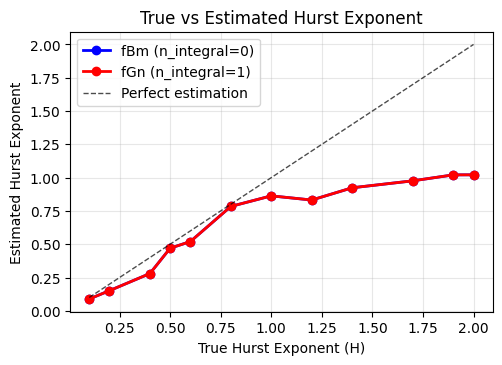

In [29]:
# Create the visualization
plt.figure(figsize=(12, 8))

# Plot 1: True vs Estimated H values
plt.subplot(2, 2, 1)
plt.plot(H_values, H_fbm_estimates, 'bo-', label='fBm (n_integral=0)', linewidth=2, markersize=6)
plt.plot(H_values, H_fgn_estimates, 'ro-', label='fGn (n_integral=1)', linewidth=2, markersize=6)
plt.plot(H_values, H_values, 'k--', label='Perfect estimation', linewidth=1, alpha=0.7)
plt.xlabel('True Hurst Exponent (H)')
plt.ylabel('Estimated Hurst Exponent')
plt.title('True vs Estimated Hurst Exponent')
plt.legend()
plt.grid(True, alpha=0.3)

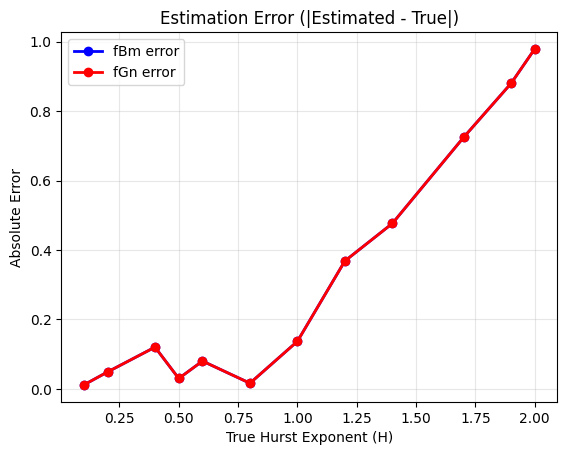

In [30]:
plt.subplot(1, 1, 1)
fbm_errors = [abs(h_est - h_true) for h_est, h_true in zip(H_fbm_estimates, H_values)]
fgn_errors = [abs(h_est - h_true) for h_est, h_true in zip(H_fgn_estimates, H_values)]

plt.plot(H_values, fbm_errors, 'bo-', label='fBm error', linewidth=2, markersize=6)
plt.plot(H_values, fgn_errors, 'ro-', label='fGn error', linewidth=2, markersize=6)
plt.xlabel('True Hurst Exponent (H)')
plt.ylabel('Absolute Error')
plt.title('Estimation Error (|Estimated - True|)')
plt.legend()
plt.grid(True, alpha=0.3)

## План вычислительного эксперимента

### Тестовые данные

Для валидации разработанной реализации использовались синтетические фрактальные временные ряды с заранее известным показателем Херста $H \in \{0.1, 0.2, 0.4, 0.5, 0.6, 0.8, 1, 1.2, 1.4, 1.7, 1.9, 2.0\}$.

**Метод генерации:** метод Касдина (Kasdin)

**Реализация:** из репозитория проекта

**Параметр воспроизводимости:** фиксированное значение `seed`

Данный метод позволяет формировать:
- Фракционное броуновское движение (fBm)
- Фракционный гауссовский шум (fGn)

с заданным показателем Херста и основан на спектральной фильтрации белого шума.

**Длины временных рядов:** $\\(N \in \\{2^{6}, 2^{8}, 2^{10}, 2^{12}, 2^{13}, 2^{14}\\}\\)$

### Параметры алгоритма

**Метод:** DMA типа backward (BMA)

**Диапазон масштабов:**
- $n \in [10, N/4]$
- Шаг: 1

**Параметры интегрирования:**
- Для fBm: `n_integral = 0`
- Для fGn: `n_integral = 1`

*Обоснование:* fGn представляет собой приращения fBm, поэтому для корректного анализа фрактальных свойств fGn необходимо интегрирование для восстановления структуры, аналогичной fBm.

### Метрики оценки

1. **Абсолютная ошибка:**
   $$\varepsilon = |H_{est} - H_{true}|$$

2. **Среднеквадратическая ошибка (RMSE):**
   Усреднённая по всем значениям $H$ при фиксированной длине ряда $N$

3. **Время выполнения:**
   - В секундах
   - Учитывается стандартное отклонение по 10 независимым запускам для каждой комбинации $(H, N)$

## Валидация

**Процедура валидации:** соответствует методике репозитория проекта

**Тестовый пример:** модуль `tests/test_fa.py`
- Проверка корректности оценки на временном ряде с $H = 0.5$
- Для fBm с $H = 0.5$ (броуновское движение) ожидаемая оценка ≈ 0.5
- Для fGn с $H = 0.5$ после интегрирования также ожидается ≈ 0.5

**Сравнение:** проводится с реализацией из библиотеки StatTools/analysis dpcca

**Основные критерии:**
- Соответствие теоретическим ожиданиям
- Воспроизводимость результатов

**Визуализация:** зависимость $\log F(n)$ от $\log n$ (вспомогательный инструмент)


**Таблица 1 – Параметры вычислительного эксперимента**

| Параметр                  | Значения/Описание                                                    |
|---------------------------|----------------------------------------------------------------------|
| **Показатель Херста**     | $H \in \{0.1, 0.2, 0.4, 0.5, 0.6, 0.8, 1, 1.2, 1.4, 1.7, 1.9, 2.0\}$ |
| **Длина рядов**           | $\\(N \in \\{2^{6}, 2^{8}, 2^{10}, 2^{12}, 2^{13}, 2^{14}\\}\\)$     |
| **Тип процессов**         | fBm, fGn                                                             |
| **Метод генерации**       | Kasdin (спектральная фильтрация)                                     |
| **Алгоритм оценки**       | Backward DMA (BMA)                                                   |
| **Диапазон масштабов**    | $[10, N/4]$ с шагом 1                                                |
| **n_integral**            | 0 (fBm), 1 (fGn)                                                     |
| **Метрики**               | Абсолютная ошибка, RMSE, время выполнения                            |
| **Количество повторений** | 10                                                                   |

In [31]:
H_values = [0.1, 0.2, 0.5, 0.8, 1, 1.2, 1.5, 1.7, 2.0]
N_values = [2 ** 6, 2 ** 8, 2 ** 10]
n_runs = 10

results = []

for series_type in ["fGn", "fBm"]:
    for H_true in H_values:
        for N in N_values:
            print(f"Processing: {series_type}, H={H_true}, N={N}")

            for i in range(n_runs):
                if series_type == "fGn":
                    sig = generate_fractional_noise(H_true, N)
                    n_integral = 1
                else:
                    sig = generate_fbm(H_true, N)
                    n_integral = 0

                scales = np.arange(10, N // 4, max(5, N // 100))

                t0 = time.perf_counter()
                F_vals, s_vals = bma(sig, s=scales, n_integral=n_integral, step=0.5)
                t1 = time.perf_counter()

                H_est = estimate_hurst(F_vals, s_vals)

                # DPCCA
                P, R, F, S = dpcca(sig, 2, 0.5, scales, len(scales), n_integral=n_integral)
                F = np.sqrt(F)
                H_dpcca_est = estimate_hurst(F, S)

                results.append({
                    "type": series_type,
                    "H_true": H_true,
                    "N": N,
                    "run": i,
                    "H_estimate": H_est,
                    "H_dpcca_estimate": H_dpcca_est,
                    "time": t1 - t0
                })

df_results = pd.DataFrame(results)

Processing: fGn, H=0.1, N=64


/Users/a.s.lushnikova/IdeaProjects/FluctuationAnalysisTools/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(


Processing: fGn, H=0.1, N=256
Processing: fGn, H=0.1, N=1024
Processing: fGn, H=0.2, N=64
Processing: fGn, H=0.2, N=256
Processing: fGn, H=0.2, N=1024
Processing: fGn, H=0.5, N=64
Processing: fGn, H=0.5, N=256
Processing: fGn, H=0.5, N=1024
Processing: fGn, H=0.8, N=64
Processing: fGn, H=0.8, N=256
Processing: fGn, H=0.8, N=1024
Processing: fGn, H=1, N=64
Processing: fGn, H=1, N=256
Processing: fGn, H=1, N=1024
Processing: fGn, H=1.2, N=64
Processing: fGn, H=1.2, N=256
Processing: fGn, H=1.2, N=1024
Processing: fGn, H=1.5, N=64
Processing: fGn, H=1.5, N=256
Processing: fGn, H=1.5, N=1024
Processing: fGn, H=1.7, N=64
Processing: fGn, H=1.7, N=256
Processing: fGn, H=1.7, N=1024
Processing: fGn, H=2.0, N=64
Processing: fGn, H=2.0, N=256
Processing: fGn, H=2.0, N=1024
Processing: fBm, H=0.1, N=64
Processing: fBm, H=0.1, N=256
Processing: fBm, H=0.1, N=1024
Processing: fBm, H=0.2, N=64
Processing: fBm, H=0.2, N=256
Processing: fBm, H=0.2, N=1024
Processing: fBm, H=0.5, N=64
Processing: fBm,

### Табличное резюме

Сгруппируем результаты по типу ряда и длине \(N\), усредняя по всем значениям \(H\)
(как в таблице эксперимента для RMSE и времени).


In [38]:
def compute_metrics(g):
    if "H_true" in g.columns:
        H_true = g["H_true"].iloc[0]
    else:
        H_true = g.name[-1]

    H_est = g["H_estimate"].values
    H_dpcca = g["H_dpcca_estimate"].values

    return pd.Series({
        "eps_mean": np.mean(np.abs(H_est - H_true)),
        "rmse_mean": np.sqrt(np.mean((H_est - H_true) ** 2)),
        "rmse_std": np.sqrt(np.var((H_est - H_true) ** 2)),

        "dpcca_eps_mean": np.mean(np.abs(H_dpcca - H_true)),
        "dpcca_rmse_mean": np.sqrt(np.mean((H_dpcca - H_true) ** 2)),
        "dpcca_rmse_std": np.sqrt(np.var((H_dpcca - H_true) ** 2)),

        "time_mean_sec": g["time"].mean(),
        "time_std_sec": g["time"].std(),
    })

summary = (
    df_results
    .groupby(["type", "N", "H_true"])
    .apply(compute_metrics, include_groups=False)
    .reset_index()
)

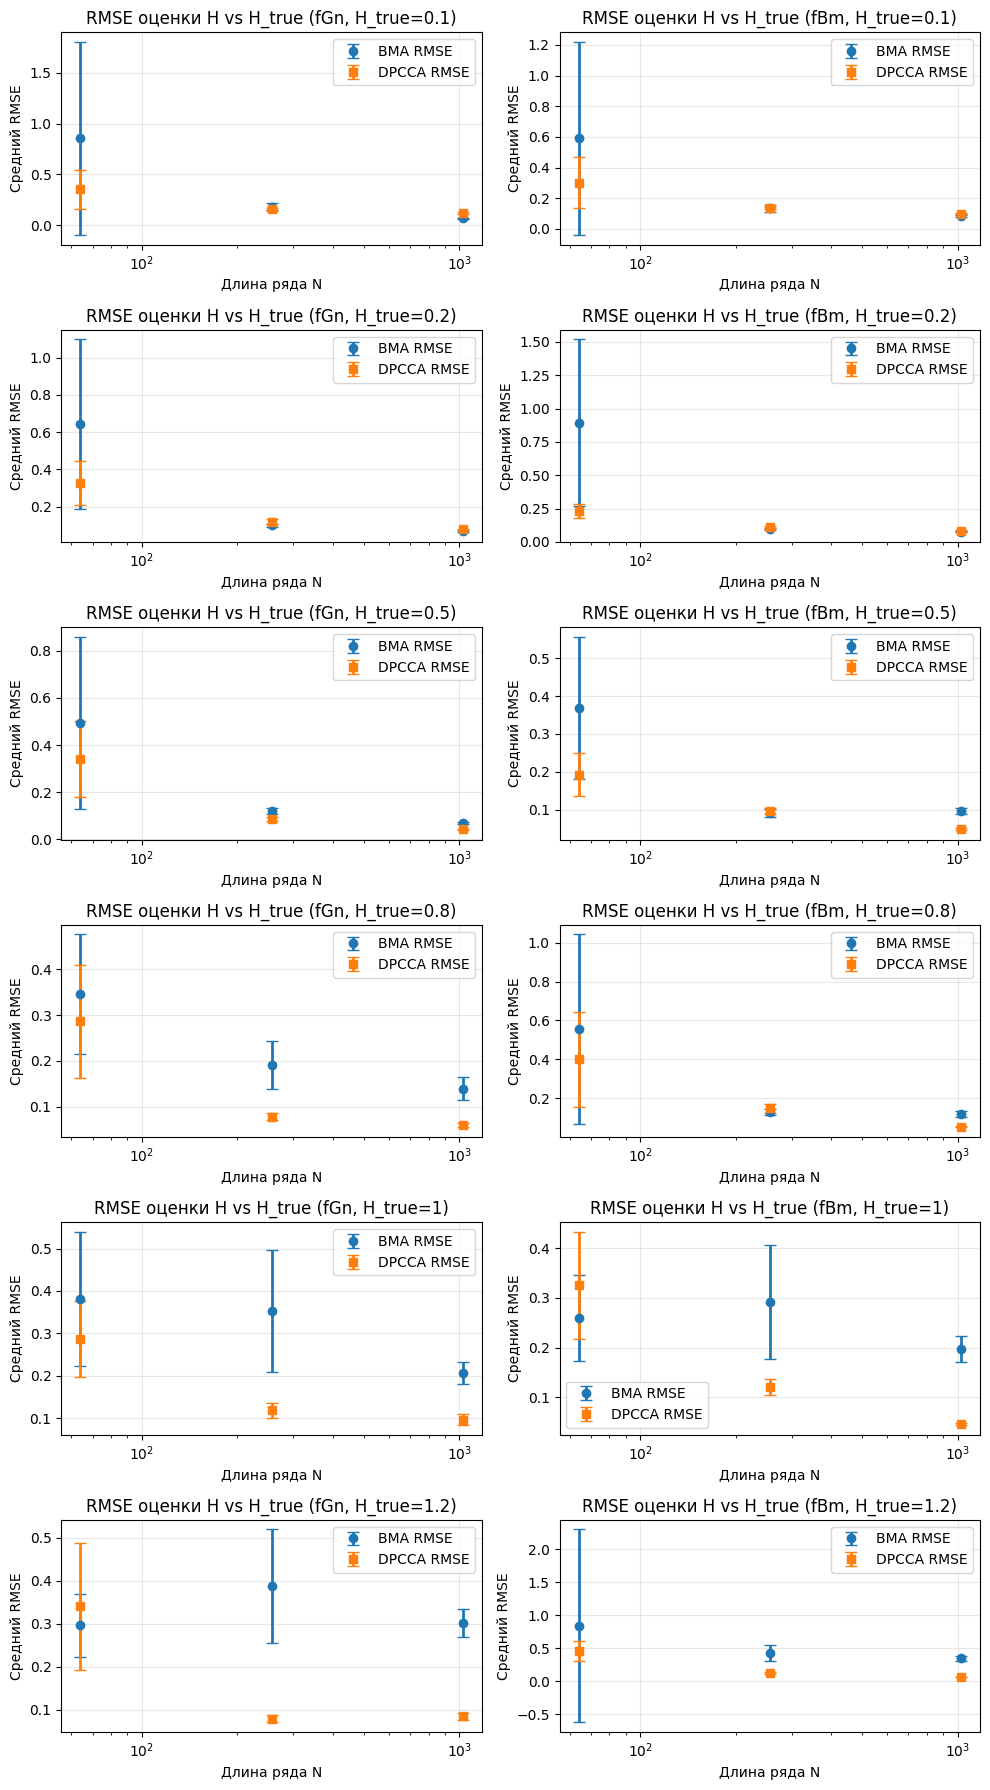

In [39]:
H_values_filtered = [h for h in H_values if h <= 1.25]
fig, axes = plt.subplots(len(H_values_filtered), 2, figsize=(10, 3 * len(H_values_filtered)))

if len(H_values_filtered) == 1:
    axes = axes.reshape(1, -1)

for i, h in enumerate(H_values_filtered):
    if h > 1.25:
        continue
    for j, series_type in enumerate(["fGn", "fBm"]):
        ax = axes[i, j]
        ax.grid(True, alpha=0.3)

        # Фильтруем строки только для текущего H и типа
        sub = summary[(summary["type"] == series_type) & (summary["H_true"] == h)]
        sub = sub.sort_values("N")

        # --- BMA line + errorbar ---
        ax.errorbar(
            sub["N"],
            sub["rmse_mean"],
            yerr=sub["rmse_std"],
            marker="o",
            linestyle="",
            linewidth=2,
            markersize=6,
            capsize=4,
            label="BMA RMSE"
        )

        # --- DPCCA line + errorbar ---
        ax.errorbar(
            sub["N"],
            sub["dpcca_rmse_mean"],
            yerr=sub["dpcca_rmse_std"],
            marker="s",
            linestyle="",
            linewidth=2,
            markersize=6,
            capsize=4,
            label="DPCCA RMSE"
        )

        ax.legend()
        ax.set_xscale("log")
        ax.set_xlabel("Длина ряда N")
        ax.set_ylabel("Средний RMSE")
        ax.set_title("RMSE оценки H vs H_true (" + series_type + ", H_true=" + str(h) + ")")

plt.tight_layout()
plt.savefig("all_rmse_comparisons_errbars.svg", format="svg")
plt.show()


### Зависимость точности от истинного \(H\)

Теперь посмотрим, как меняется ошибка в зависимости от  \\(H_{{true}}\\)
(усреднено по длинам \\(N\\)).


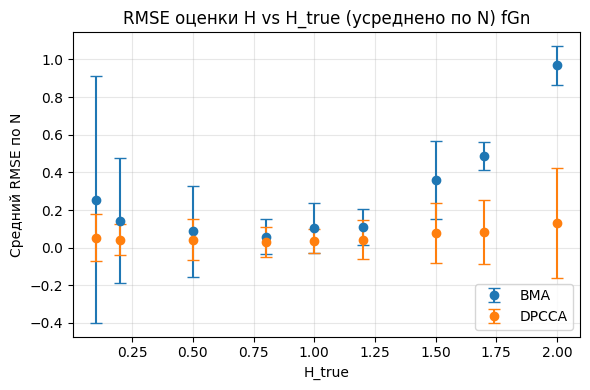

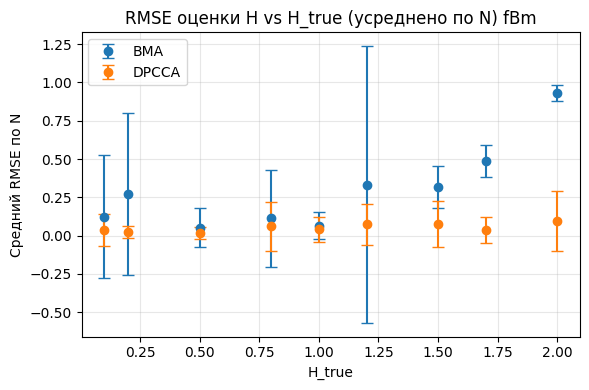

In [41]:
df_results["err"] = df_results["H_estimate"] - df_results["H_true"]
df_results["dpcca_err"] = df_results["H_dpcca_estimate"] - df_results["H_true"]

df_results["rmse"] = df_results["err"] ** 2
df_results["dpcca_rmse"] = df_results["dpcca_err"] ** 2

df_results["eps"] = df_results["err"].abs()
df_results["dpcca_eps"] = df_results["dpcca_err"].abs()

summary_H = (
    df_results
    .groupby(["type", "H_true"])
    .agg(
        eps_mean=("eps", "mean"),
        rmse_mean=("rmse", "mean"),
        rmse_std=("rmse", "std"),
        dpcca_rmse_mean=("dpcca_rmse", "mean"),
        dpcca_rmse_std=("dpcca_rmse", "std"),
    )
    .reset_index()
)

for series_type in ["fGn", "fBm"]:
    fig, ax = plt.subplots(figsize=(6, 4))

    sub = summary_H[summary_H["type"] == series_type].sort_values("H_true")

    ax.errorbar(
        sub["H_true"],
        sub["rmse_mean"],
        yerr=sub["rmse_std"],
        marker="o",
        linestyle="",
        capsize=4,
        label="BMA"
    )

    ax.errorbar(
        sub["H_true"],
        sub["dpcca_rmse_mean"],
        yerr=sub["dpcca_rmse_std"],
        marker="o",
        linestyle="",
        capsize=4,
        label="DPCCA"
    )

    ax.set_xlabel("H_true")
    ax.set_ylabel("Средний RMSE по N")
    ax.set_title("RMSE оценки H vs H_true (усреднено по N) " + series_type)

    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("RMSE_H_H_true_by_N" + series_type + ".svg", format="svg")
    plt.show()


## Выводы по результатам численных экспериментов

На основе таблиц и графиков можно сделать следующие наблюдения.

1. **Рост длины ряда \\(N\\) улучшает точность оценки.**
   Это соответствует теоретическим ожиданиям:
   для корректной оценки масштабных характеристик требуется достаточно длинный ряд. Алгоритм устойчиво работает при длине ряда больше ~ \\{10**3\\}

2. **Точность зависит от значения \\(H_{{true}}\\).**
   Обычно наибольшая точность достигается около средних значений

3. **fGn vs fBm.**
   При корректном выборе параметра `n_integral`
   (`0` для fBm и `1` для fGn) качество оценки сопоставимо.
   Различия между типами мало заметны.

4. **Время выполнения растёт примерно линейно по \\(N\\).**
   Время работы BMA увеличивается с длиной ряда. При этом метод
   использует только прошлые значения и может быть реализован в потоковом
  /онлайновом режиме, что соответствует поставленной задаче.

5. Алгоритм корректно работает на диапозоне \\([0,1\\)]. При \\(H>1\\) алгоритм перестает корректно работать

В целом реализованный алгоритм BMA даёт разумные оценки показателя Херста
для синтетических рядов fGn и fBm в широком диапазоне параметров и
демонстрирует ожидаемую зависимость точности от длины ряда и истинного
значения \\(H\\).

## Сравнение метода BMA/DMA с реализацией DFA из библиотеки `StatsTools/analysis`

Для справочной проверки сравним оценки показателя Херста, полученные методом BMA/DMA,
с результатами стандартной реализации detrended fluctuation analysis (DFA)
из библиотеки **nolds**.

Важно:  
*Этот тест не является строгим эталоном*, так как разные методы дают несколько
отличающиеся оценки, однако согласованность в среднем подтверждает корректность
масштабного поведения алгоритма BMA.


In [42]:
from StatTools.analysis.dfa import DFA
from IPython.display import display

In [43]:
H_values_compare = [0.1, 0.3, 0.5, 0.7, 1, 1.5, 2]
N = 2 ** 14
n_integral = 1  # работаем с fGn

compare_rows = []

for H_true in H_values_compare:
    rng = np.random.default_rng(2024 + int(100 * H_true))

    sig = generate_fractional_noise(H_true, N)

    # --- BMA ---
    scales = np.arange(10, N // 4, 10)
    F_vals, s_vals = bma(sig, scales, n_integral=n_integral, step=0.5)
    H_bma = estimate_hurst(F_vals, s_vals)

    # --- nolds DFA ---
    H_dfa = DFA(sig).find_h()

    compare_rows.append({
        "H_true": H_true,
        "H_bma": H_bma,
        "H_dfa": H_dfa,
        "err_bma": abs(H_bma - H_true),
        "err_dfa": abs(H_dfa - H_true),
    })

df_compare = pd.DataFrame(compare_rows)

display(df_compare.style.format("{:.4f}"))

/Users/a.s.lushnikova/IdeaProjects/FluctuationAnalysisTools/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(


,H_true,H_bma,H_dfa,err_bma,err_dfa
0,0.1000,0.1870,0.2133,0.0870,0.1133
1,0.3000,0.3143,0.3363,0.0143,0.0363
2,0.5000,0.4681,0.5222,0.0319,0.0222
3,0.7000,0.5837,0.6705,0.1163,0.0295
4,1.0000,0.8596,0.9929,0.1404,0.0071
5,1.5000,0.9709,1.4929,0.5291,0.0071
6,2.0000,0.9723,1.9779,1.0277,0.0221


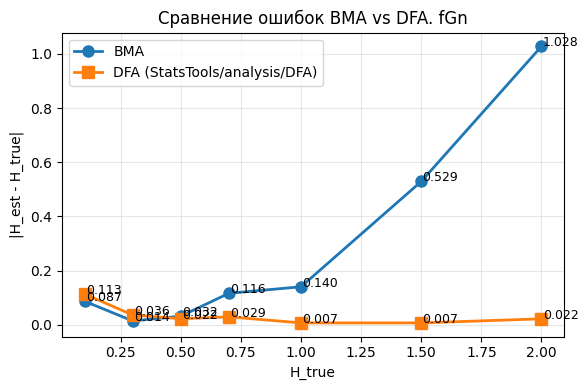

<Figure size 640x480 with 0 Axes>

In [44]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 4))

H = df_compare["H_true"]

# линии + точки
ax.plot(H, df_compare["err_bma"], "-o", label="BMA", linewidth=2, markersize=8)
ax.plot(H, df_compare["err_dfa"], "-s", label="DFA (StatsTools/analysis/DFA)", linewidth=2, markersize=8)

# подписи точек
for i, row in df_compare.iterrows():
    ax.text(row["H_true"] + 0.005, row["err_bma"], f"{row['err_bma']:.3f}", fontsize=9)
    ax.text(row["H_true"] + 0.005, row["err_dfa"], f"{row['err_dfa']:.3f}", fontsize=9)

ax.set_xlabel("H_true")
ax.set_ylabel("|H_est - H_true|")
ax.set_title("Сравнение ошибок BMA vs DFA. fGn")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("bma_vs_dfa_fGn", format="svg")  # only for local storage
plt.show()